In [1]:
# Install library
!pip install contractions
!pip install scikit-learn
!pip install -q Sastrawi
!pip install -q  googletrans==4.0.0-rc1 #untuk analisis narasi
!pip install -q langdetect  # Install pustaka deteksi bahasa

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Preprocessing
from bs4 import BeautifulSoup
import re
import unicodedata
import nltk
import contractions
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from wordcloud import WordCloud
from collections import Counter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 13.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
# Load  dataset
url = 'https://raw.githubusercontent.com/22bayusetia/PyCuan/main/Sentiment%20Analysis/data_finance.csv'
# url = 'https://raw.githubusercontent.com/hairulysin/Algoritma_Academy/main/dataset.csv'
df = pd.read_csv(url, delimiter=',', encoding='latin-1', header=None)
df = df.drop(0)
df.columns = ['label', 'en_text', 'id_text']
df = df[['label', 'id_text', 'en_text']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3934 entries, 1 to 3934
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    3934 non-null   object
 1   id_text  3934 non-null   object
 2   en_text  3934 non-null   object
dtypes: object(3)
memory usage: 92.3+ KB


In [3]:
nltk.download('stopwords')
nltk.download('punkt')

# Load stopwords for Indonesian
indonesian_stopwords = set(nltk.corpus.stopwords.words('indonesian'))

# Load Sastrawi stemmer and stopword remover
factory1 = StopWordRemoverFactory()
stopword_sastrawi = factory1.create_stop_word_remover()

factory2 = StemmerFactory()
stemmer_sastrawi = factory2.create_stemmer()

# Data preprocessing functions

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def stopwords_removal(words, language):
    if language == 'english':
        list_stopwords = nltk.corpus.stopwords.words('english')
    elif language == 'indonesian':
        list_stopwords = indonesian_stopwords
    return [word for word in words if word not in list_stopwords]

def preprocess_text_sastrawi(text):
    tokens = nltk.word_tokenize(text)
    tokens = [stopword_sastrawi.remove(token) for token in tokens]
    # tokens = [stemmer_sastrawi.stem(token) for token in tokens if token != '']
    return " ".join(tokens)

def pre_process_text(text, language):
    text = text.lower()
    text = strip_html_tags(text)
    text = text.translate(text.maketrans("\n\t\r", "   "))
    text = remove_accented_chars(text)
    text = contractions.fix(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text, re.I | re.A)
    text = re.sub(' +', ' ', text)
    text = preprocess_text_sastrawi(text) if language == 'indonesian' else text
    return text

# Apply data preprocessing
df['en_text'] = df['en_text'].apply(lambda x: pre_process_text(x, 'english'))
df['id_text'] = df['id_text'].apply(lambda x: pre_process_text(x, 'indonesian'))
df = df.drop_duplicates(subset=['en_text', 'id_text'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-3-fd4633374d41>:17: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


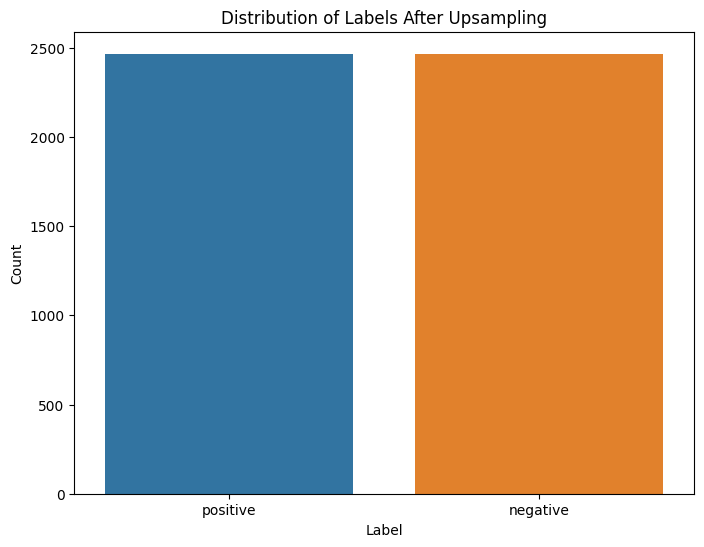

In [4]:
# Upsample the minority class after train-validation-test split
data_majority = df[df['label'] == "positive"]
data_minority = df[df['label'] == "negative"]

data_minority_upsampled = resample(data_minority,
                                   replace=True,
                                   n_samples=data_majority.shape[0],
                                   random_state=123)

df_balance_upsampled = pd.concat([data_majority, data_minority_upsampled])
df_balanced_upsampled = df.drop_duplicates(subset=['en_text', 'id_text'])

# Visualize the distribution of labels before upsampling
# plt.figure(figsize=(8, 6))
# sns.countplot(data=df, x='label')
# plt.xlabel('Label')
# plt.ylabel('Count')
# plt.title('Distribution of Labels Before Upsampling')
# plt.show()

# Visualize the distribution of labels after upsampling
plt.figure(figsize=(8, 6))
sns.countplot(data=df_balance_upsampled, x='label')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels After Upsampling')
plt.show()

In [5]:
# Split data (80:10:10)
X_train, X_temp, y_train, y_temp = train_test_split(df_balance_upsampled.en_text, df_balance_upsampled.label, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert text sequences to dense feature vectors using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [6]:
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier with validation set
rf_classifier.fit(X_train_tfidf, y_train)
y_pred = rf_classifier.predict(X_test_tfidf)

# Evaluate the model on training, validation, and test sets
train_acc = rf_classifier.score(X_train_tfidf, y_train)
val_acc = rf_classifier.score(X_val_tfidf, y_val)
test_acc = rf_classifier.score(X_test_tfidf, y_test)

print('Train Accuracy:', train_acc)
print('Validation Accuracy:', val_acc)
print('Test Accuracy:', test_acc)

Train Accuracy: 1.0
Validation Accuracy: 0.9918864097363083
Test Accuracy: 0.9838056680161943


In [7]:
# Metrics Evaluasi lain
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Precision: 0.984287283837274
Recall: 0.9838056680161943
F1 Score: 0.9837864541758248


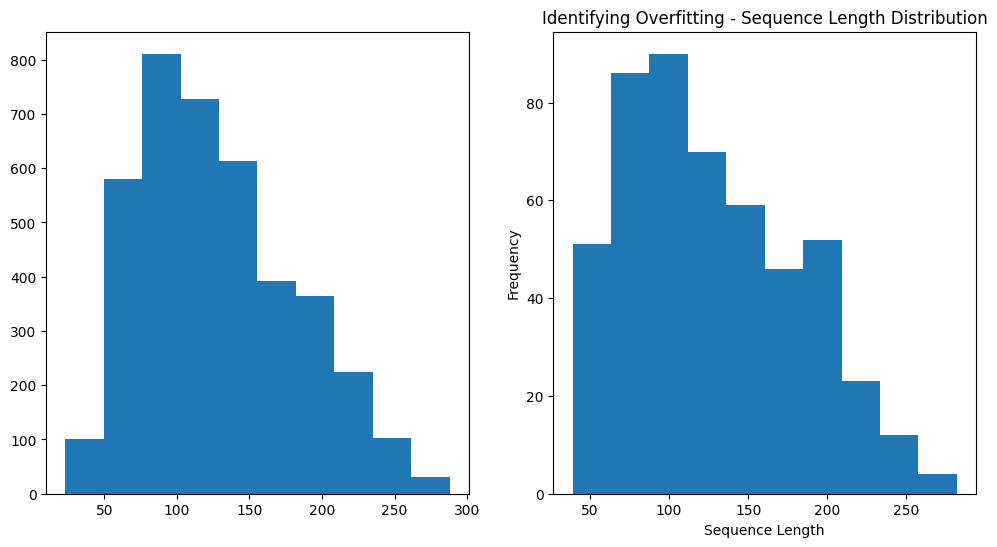

In [8]:
train_lens = [len(s) for s in X_train]
val_lens = [len(s) for s in X_val]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(val_lens)
plt.title('Identifying Overfitting - Sequence Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

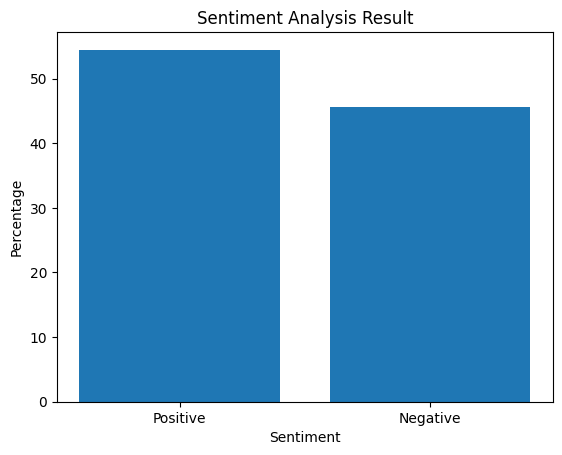

In [9]:
# Visualize sentiment prediction distribution
predicted_sentiments = rf_classifier.predict(X_test_tfidf)
positive_percentage = (predicted_sentiments == 'positive').sum() / len(predicted_sentiments) * 100
negative_percentage = 100 - positive_percentage

plt.bar(['Positive', 'Negative'], [positive_percentage, negative_percentage])
plt.xlabel('Sentiment')
plt.ylabel('Percentage')
plt.title('Sentiment Analysis Result')
plt.show()

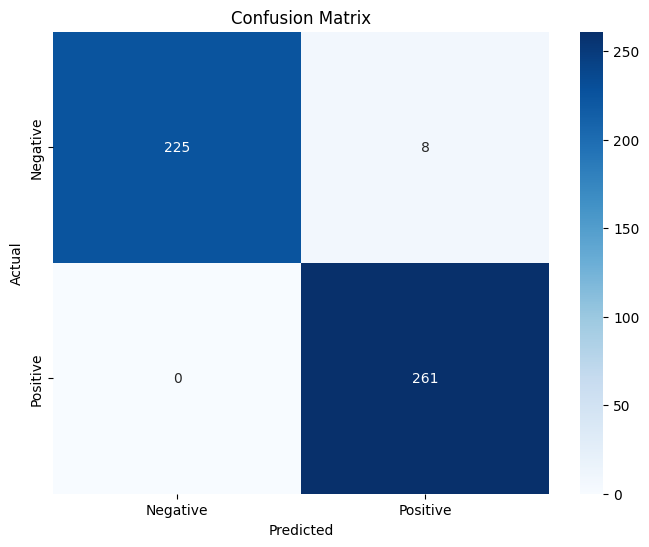

In [10]:
from sklearn.metrics import confusion_matrix

y_pred = rf_classifier.predict(X_test_tfidf)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [11]:
# Misclassified samples
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true != pred]
misclassified_texts = X_test.iloc[misclassified_indices]

# Print misclassified samples
for i, text in zip(misclassified_indices, misclassified_texts):
    print(f"Actual: {y_test.iloc[i]}, Predicted: {y_pred[i]}, Text: {text}")

Actual: negative, Predicted: positive, Text: finnish textiles and clothing group marimekko oyj posted a net profit of 799 mln euro 104 mln for 2006 compared to 84 mln euro 109 mln for 2005 
Actual: negative, Predicted: positive, Text: employing 112 in finland and 280 abroad the unit recorded firstquarter 2007 sales of 86 mln eur with an operating loss of 16 mln eur 
Actual: negative, Predicted: positive, Text: in this case the effect would be negative in finland 
Actual: negative, Predicted: positive, Text: operating profit fell to eur 151 mn from eur 246 mn in 2006 
Actual: negative, Predicted: positive, Text: in october upm reported a thirdquarter net loss of euro86 million 110 million compared with a net profit of euro120 million in 2007 
Actual: negative, Predicted: positive, Text: finlandbased stockmann group has closed seven franchising sports stores nike in russia 
Actual: negative, Predicted: positive, Text: however this increases signaling traffic which wastes network resource

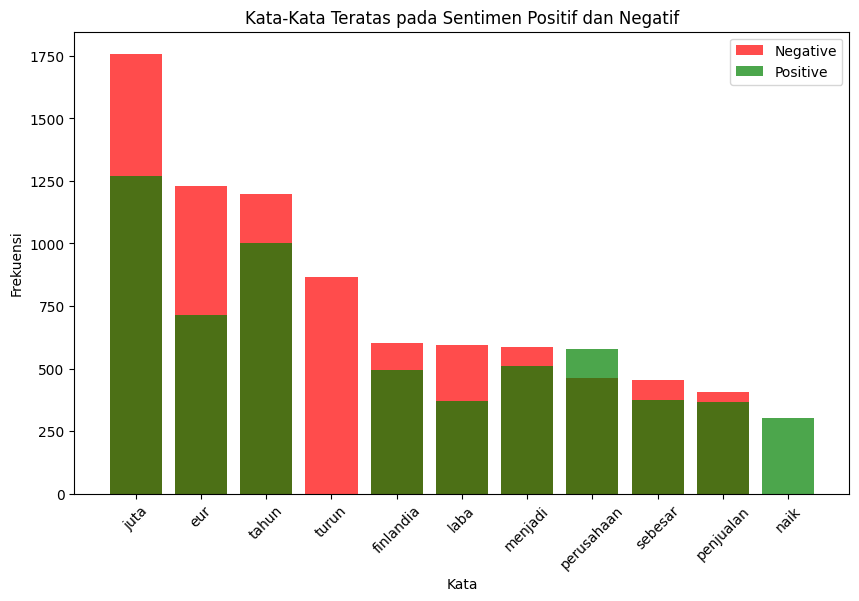

In [12]:
# Memisahkan dataset berdasarkan label sentimen
positive_texts = df_balance_upsampled[df_balance_upsampled['label'] == 'positive']['id_text']
negative_texts = df_balance_upsampled[df_balance_upsampled['label'] == 'negative']['id_text']

# Fungsi untuk mendapatkan kata-kata teratas
def get_top_words(texts, n=10):
    all_words = " ".join(texts).split()
    word_counts = Counter(all_words)
    top_words = word_counts.most_common(n)
    return top_words

# Dapatkan kata-kata teratas untuk sentimen positif dan negatif
top_positive_words = get_top_words(positive_texts)
top_negative_words = get_top_words(negative_texts)

positive_words, positive_word_counts = zip(*top_positive_words)
negative_words, negative_word_counts = zip(*top_negative_words)

# Plot kata-kata paling umum
plt.figure(figsize=(10, 6))
plt.bar(negative_words, negative_word_counts, color='red', alpha=0.7, label='Negative')
plt.bar(positive_words, positive_word_counts, color='green', alpha=0.7, label='Positive')
plt.xlabel('Kata')
plt.ylabel('Frekuensi')
plt.title('Kata-Kata Teratas pada Sentimen Positif dan Negatif')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [19]:
from langdetect import detect
from googletrans import Translator
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

translator = Translator()
narrative = "Revision of Subsidized Fertilizer Policy, Now Farmers Can Redeem Using KTP"
# Deteksi bahasa narasi
language = detect(narrative)

# Jika bahasa narasi bukan bahasa Inggris, terjemahkan ke bahasa Inggris
if language != 'en':
    narrative1 = translator.translate(narrative, dest='en').text
    narrative_tfidf = tfidf_vectorizer.transform([narrative1])
else:
    narrative_tfidf = tfidf_vectorizer.transform([narrative])

# Prediksi sentimen
predicted_sentiment = rf_classifier.predict(narrative_tfidf)
sentiment_probability = rf_classifier.predict_proba(narrative_tfidf)[0, 1]

threshold = 0.5  # Tresholdnya diatur sesuai kebutuhan
sentiment = "Positive" if sentiment_probability > threshold else "Negative"

# Print hasil prediksi
print("Text:", narrative)
print("Sentiment Probability:", sentiment_probability)
print("Sentiment:", sentiment)


Text: Revision of Subsidized Fertilizer Policy, Now Farmers Can Redeem Using KTP
Sentiment Probability: 0.66
Sentiment: Positive


In [14]:
# from sklearn.metrics import precision_recall_curve

# # Prediksi probabilitas kelas
# class_probabilities = rf_classifier.predict_proba(X_val_tfidf)[:, 1]

# # Hitung precision dan recall untuk berbagai threshold
# precision, recall, thresholds = precision_recall_curve(y_val == 'positive', class_probabilities)

# # Pilih threshold terbaik berdasarkan F1 Score
# f1_scores = 2 * (precision * recall) / (precision + recall)
# best_threshold = thresholds[np.argmax(f1_scores)]

# # Gunakan threshold terbaik
# print("Best Threshold:", best_threshold)